# Unsupervised Learning
*By Kalika Kay Curry*

I decided to use the results from the 2014 boston marathon to do a bit of exploratory data analysis and use some unsupervised learning models. I have decided to go with the most recent data set available, knowing that if another question should arise, I can retrieve the data from the other csv files.

In [68]:
#import files
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from collections import Counter
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import umap
from sklearn.cluster import KMeans
from sklearn import metrics
from sklearn.mixture import GaussianMixture

In [69]:
#open the 2014 dataset.
runners = pd.read_csv("results/2014/results.csv")
runners.shape

(31984, 21)

# Data Exploration


A quick understanding of Boston marathon [divisions](https://en.wikipedia.org/wiki/Boston_Marathon#Divisions).

In [70]:
#A summary of missing variables represented as a percentage of the total missing content. 
def missingness_summary(df, print_log=False, sort='ascending'):
  s = df.isnull().sum()*100/df.isnull().count()
    
  if sort.lower() == 'ascending':
    s = s.sort_values(ascending=True)
  elif sort.lower() == 'descending':
    s = s.sort_values(ascending=False)  
  if print_log: 
    print(s)
  
  return pd.Series(s)

In [71]:
#A dataframe containing data for reports - of missing values, datatypes and unique values for all columns.
summary = missingness_summary(runners)
report = pd.concat([summary.rename('nullCount'), runners.dtypes.reindex(summary.index).rename('dType')], join='inner', axis=1)
report = pd.concat([report, runners.nunique().reindex(summary.index).rename('nUnique')], join='inner', axis=1)
report

,nullCount,dType,nUnique
10k,0.000000,object,2766
country,0.000000,object,78
20k,0.000000,object,5375
half,0.000000,object,5651
5k,0.000000,object,1491
30k,0.000000,object,8090
pace,0.000000,float64,727
overall,0.000000,int64,31931
35k,0.000000,object,9516
bib,0.000000,object,31984


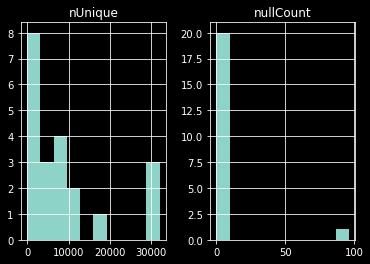

In [72]:
report.hist()
plt.show()

In [73]:
#Deleted the code, but there was one null city observation for Brazil.
# Is that the only observation for Brazil?
runners[runners.country == 'BRA']

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
52,35.22,"Aparecida da Silva, Adriana",16,88.65,F,32,151.30,F24,16,NaN,...,111,5.78,NaN,106.88,17.50,74.73,70.82,BRA,Sao Paulo,143.40
361,35.77,"Apovian, Marcelo",27,89.75,M,41,159.25,356,282,NaN,...,309,6.08,NaN,108.25,18.40,75.65,71.78,BRA,Sao Paulo,148.53
561,45.88,"Saeki, Kunihiro",1580,117.42,M,42,220.33,586,8781,NaN,...,12518,8.42,NaN,143.53,23.00,98.30,93.17,BRA,Sao Paulo,207.58
746,39.42,"Cerize, Pedro L. Sr.",2040,102.98,M,44,260.43,791,12848,NaN,...,21934,9.93,NaN,127.28,19.45,85.02,80.47,BRA,Sao Paulo,184.65
1620,40.58,"Sell Ribeiro Neto, Affonso Nilton Walmor",968,101.05,M,35,173.62,1832,1243,NaN,...,1314,6.63,NaN,121.58,20.28,85.28,80.83,BRA,Florianopolis,163.47
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31141,51.68,"Cardoso, Ivan",2201,131.20,M,47,250.15,35008,12013,NaN,...,20067,9.55,NaN,166.13,25.75,109.80,103.95,BRA,Natal,237.18
31142,48.83,"Hall-Nielsen, Peter",1937,124.33,M,54,264.28,35009,13129,NaN,...,22542,10.08,NaN,160.23,24.07,103.90,98.37,BRA,Belo Horizonte,245.93
31143,51.12,"Iacoponi, Ruy Ferreira Jr.",961,128.40,M,55,237.58,35010,10884,NaN,...,17438,9.07,NaN,156.90,25.07,107.67,102.12,BRA,Sao Bernardo Do Campo,223.90
31144,51.90,"Cruz, Carlos Henrique",1736,129.80,M,47,223.72,35011,9220,NaN,...,13535,8.53,NaN,156.07,26.57,109.62,103.90,BRA,Rio De Janeiro,211.43


# Data Cleaning
I want to see if the table can predict what country a runner is in based on this data. 

### Hypothesis:
$H =$ *A runners marathon charateristics are related to the country.*

$H_0 =$ *Marathon characteristics have nothing to do with the country.* 


Variables to exclude:
* Name - unique identifier, without contributing information to the overall generalizations I want to make about the data.
* State - dead give away to what country the runner might be from. Also, not observation has one. 
* City - same consequence as the state.
* ctz - only 4 percent of obersvations contain this field. I don't know what to do with it. 
* bib - unique identifier, much like name. 
* Country is my predictions column. 
* Gender - I gave it some thought. I can drop this one. 


Gender is a categorical variable. Do I want to treat it as a dummy or do I want to label it a 1 or a zero? I like ones and zeroes in the same column; but I hear that machine learning models prefer the dummies. Life is easier with the dummies. 

Most of the numerical data will need to be converted to a float. . . but does it contain a sneaky null though? I'll find out the hard way.

In [74]:
#I learned the hard way - save the clean data to a different variable.
marathon = runners.drop(columns=['name', 'state', 'city', 'ctz', 'bib', 'country', 'gender'])

#convert the numerical data.
cols = ['10k', 'division', '25k', 'official', 'genderdiv', '35k', 'overall', 'pace', '30k', '5k','half', '20k', '40k']
marathon[cols] = marathon[cols].apply(pd.to_numeric, errors='coerce')
#is there a boo-boo?
missingness_summary(marathon)

division     0.000000
age          0.000000
official     0.000000
genderdiv    0.000000
overall      0.000000
pace         0.000000
35k          0.106303
40k          0.121936
30k          0.125063
10k          0.156328
20k          0.159455
5k           0.162581
half         0.225113
25k          0.675338
dtype: float64

In [75]:
problems = ['25k', '35k', '30k', '5k','half', '20k', '40k']
runners[runners.index.isin(marathon[marathon['25k'].isna()].index)]

,10k,name,division,25k,gender,age,official,bib,genderdiv,ctz,...,overall,pace,state,30k,5k,half,20k,country,city,40k
1682,44.07,"Boden, Jeffrey G",3219,-,M,38,206.72,1905,6647,NaN,...,8284,7.90,FL,140.97,21.47,96.22,91.02,USA,Coral Gables,195.22
3189,-,"Haushalter, Jeff",647,-,M,47,195.82,3622,4815,NaN,...,5463,7.48,GA,-,-,-,-,USA,Atlanta,184.62
7417,-,"Dennier, Ana C",1650,-,F,42,264.28,8452,9412,NaN,...,22540,10.08,ON,-,-,-,-,CAN,Toronto,251.72
9547,-,"Gomes, Claudia",129,-,F,36,181.80,10932,153,NaN,...,2649,6.95,NaN,-,-,-,-,BRA,Sao Paulo,164.78
10101,82.88,"Biancheri, Andrew",2919,-,M,45,440.08,11566,17563,NaN,...,31911,16.77,MA,300.68,38.25,195.03,183.82,USA,Westborough,416.33
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31883,105.53,"Senatillaka, David A.",5901,-,M,33,423.93,35807,17532,NaN,...,31854,16.32,MA,299.22,59.75,212.20,-,USA,Malden,405.18
31904,83.67,"Eklund, Sean M.",5754,-,M,30,351.88,35830,17027,NaN,...,30672,13.43,MA,267.12,37.97,200.07,184.68,USA,Lowell,340.27
31938,68.97,"Leone, William T.",2915,-,M,49,432.35,35865,17550,NaN,...,31890,15.80,MA,283.33,33.23,179.13,169.15,USA,Wayland,-
31974,76.45,"Foley, Alison M.",6973,-,F,29,431.73,35903,14339,NaN,...,31887,15.52,MA,279.47,35.63,183.28,166.43,USA,Wellesley,-


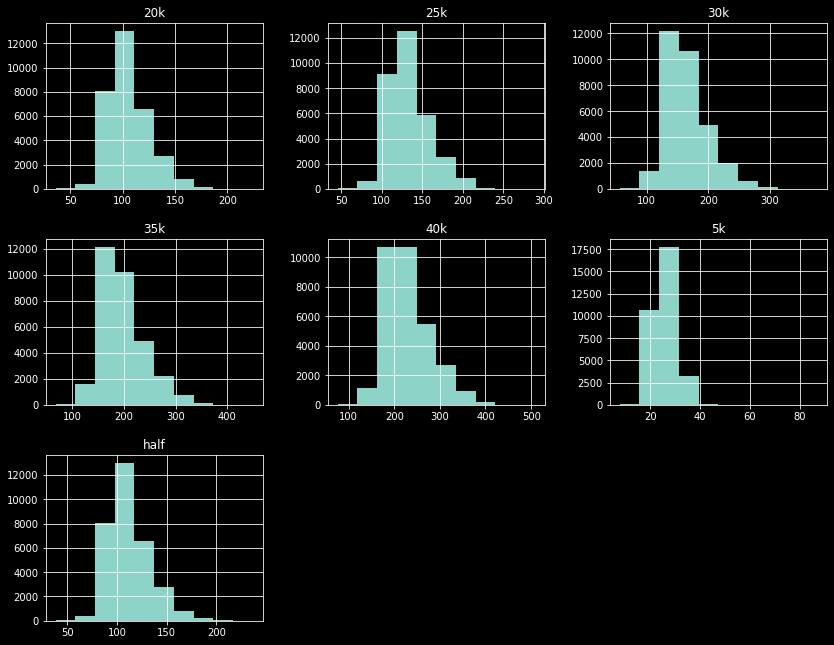

In [76]:
plt.style.use(['dark_background'])
marathon[problems].hist(figsize=(14, 11))
plt.show()

In [77]:
#A map designed for a correlation matrix.  
def the_best_map(corr):
  mask = np.zeros_like(corr)
  mask[np.triu_indices_from(mask)] = False
  with sns.axes_style("white"):
    f, ax = plt.subplots(figsize=(15, 15))
    ax = sns.heatmap(data=corr, annot=True, square=True, fmt='.1g', center=0.7, mask=mask, vmin=0, vmax=1)
  plt.show()

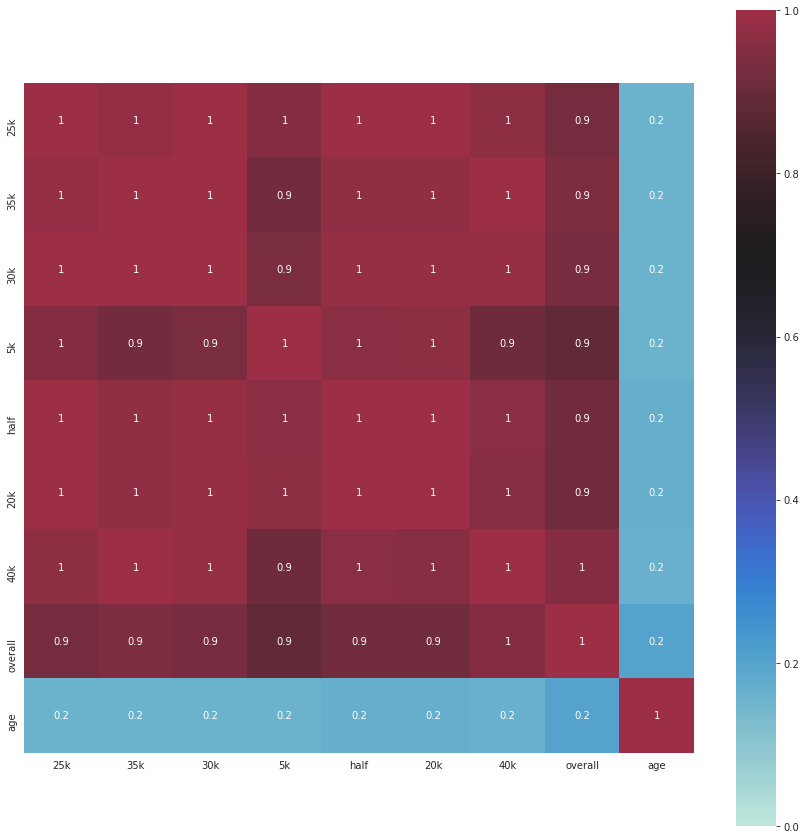

In [78]:
the_best_map(marathon[['25k', '35k', '30k', '5k','half', '20k', '40k', 'overall', 'age']].corr())

In [79]:
marathon[problems].min()

25k     45.80
35k     67.42
30k     56.45
5k       7.75
half    38.03
20k     36.10
40k     76.10
dtype: float64

# Feature Engineering


### *problems*
Ah. Those problem columns DO contain sneaky null values. 

After giving it a very long, hard thought - I have decided to fill those null values in with zero. No one ran the race in zero seconds. I'm looking for variance and clusterings, not speed, right now, but do Brazilians run faster than everyone?

Well, we're not going to be able to tell that on average, I don't think. When we look at these values overall; just know that a zero means that they didn't participate. Ten percent shouldn't be too outliery. We'll see. I might have to fix it. 

* Fill null values with 0.0

### *whew* - y variable

Because I haven't dropped any observations, I feel safe just assigning the y variable, Country, from the runners dataframe. I decided earlier to drop the column from my marathon dataframe and handled it before my assignment.

* set the y variable to the country.

### Normalize the data

* scale the data using the standard scalar. 

In [101]:
y = runners['country']
X = marathon.fillna(0)
missingness_summary(X)

10k          0.0
division     0.0
25k          0.0
age          0.0
official     0.0
genderdiv    0.0
35k          0.0
overall      0.0
pace         0.0
30k          0.0
5k           0.0
half         0.0
20k          0.0
40k          0.0
dtype: float64

In [81]:
#Quick look at averages, quaratiles, and standard deviations.
X.describe()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
count,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000,31984.000000
mean,51.718298,1932.563032,132.709723,42.407079,242.997314,8051.044741,196.648339,15939.587825,9.275658,164.365402,25.713685,111.413195,105.543107,228.722255
std,9.189281,1715.228694,27.758446,11.316496,52.300431,4754.005626,42.444377,9232.978224,1.992486,34.427329,4.447068,21.692902,20.209809,49.775681
min,0.000000,1.000000,0.000000,18.000000,80.600000,1.000000,0.000000,1.000000,3.080000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,45.370000,610.000000,115.100000,33.000000,205.527500,3972.000000,167.050000,7943.750000,7.850000,140.580000,22.630000,96.750000,91.700000,193.700000
50%,50.320000,1425.000000,128.670000,42.000000,232.370000,7970.000000,188.120000,15939.500000,8.870000,157.700000,25.080000,107.775000,102.100000,218.780000
75%,57.150000,2611.000000,147.555000,50.000000,273.235000,11968.000000,220.120000,23935.250000,10.430000,182.785000,28.455000,123.030000,116.480000,257.405000
max,112.380000,6979.000000,289.020000,81.000000,538.880000,17575.000000,449.330000,31931.000000,20.570000,376.380000,86.950000,236.670000,224.350000,508.350000


In [82]:
scale = StandardScaler()
X_std = scale.fit_transform(X)

I "*suspect*" that I still have a few categorical values in here. I'm excited to get going, though, so I'm going to run my model and suffer the consequences. 


# Model Selection
*Combining dimesionality reduction with visualization for model selection.*


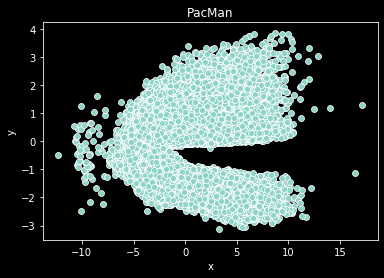

In [83]:
#Principle Component Analysis (PCA) reduction and visualization

# We just want the first two principal components
pca = PCA(n_components=2)

# We get the components by calling fit_transform method with our data
pca_components = pd.DataFrame(pca.fit_transform(X_std), columns=['x', 'y'])

#Plot it. 
ax = sns.scatterplot(data=pca_components, x='x', y='y')
ax.set_title('PacMan')
plt.show()

There is a way to determine if my y values are going to be found in this thing; however, I have a hypothesis to think about. Are there any discernable countries in this thing? I can see that there's some cluster type thing around the left side of the grap. There's almost a split in the middle - so it ALMOST looks like this is a three cluster graph. It could be two. Is it two?

I have 78 different countries. This is not looking good for my hypothesis: $H = $  *A runners marathon charateristics are related to the country.*

What does the U map decomposition look like? I don't want to subject anyone to the extensive research. 

Understand that I have run a few of them and selected the one that best represented the data, based on my hypothesis. 

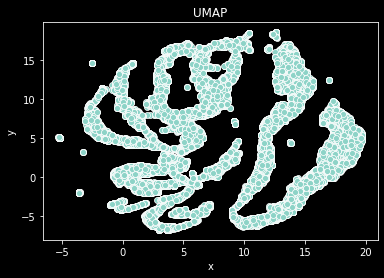

In [84]:
#UMAP for dimensionality reduction and visualization
umap_results = pd.DataFrame(umap.UMAP(n_neighbors=5, min_dist=0.013, metric='minkowski').fit_transform(X_std), columns=['x', 'y'])
#Plot it. 
ax = sns.scatterplot(data=umap_results, x='x', y='y')
ax.set_title('UMAP')
plt.show()

This is still not looking good for my hypothesis and I'm starting to move toward the thought that I was incorrect in my assertions. Perhaps, the features selected have nothing to with a person's country of origin. 

I have an okay visual representation of my data model. I still choose to assert that there are 78 clusters total. This is what I will choose as I run my models and I will adjust from that assertion.  

In [85]:
#KMeans++
# Defining the k-means
kmeans_cluster = KMeans(n_clusters=78, random_state=123)

# Fit model
kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

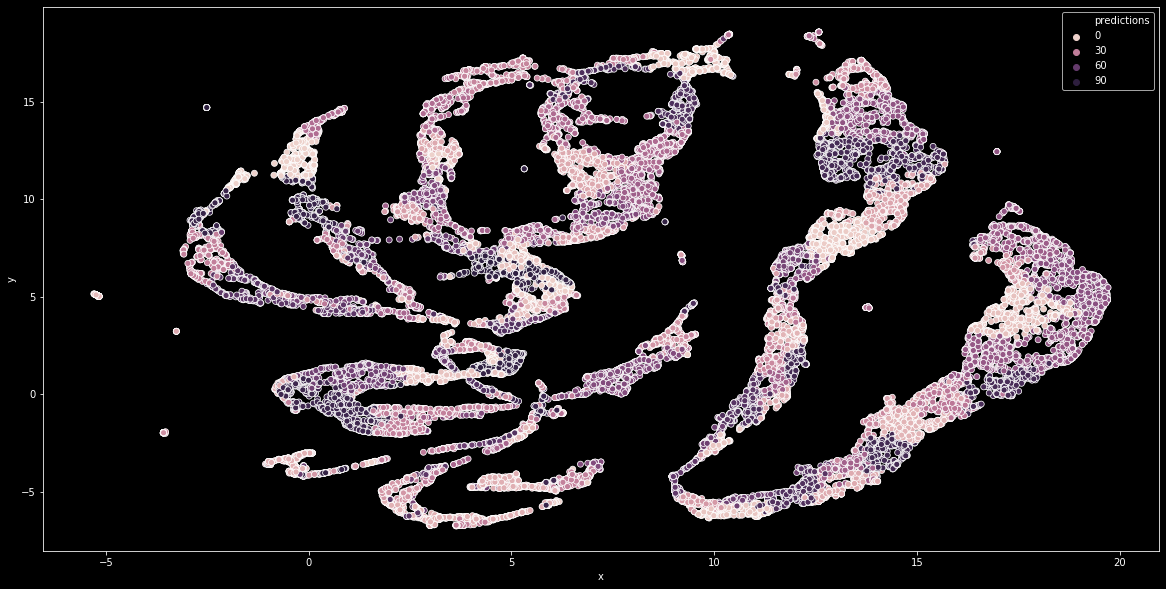

In [86]:
umap_results['predictions'] = y_pred
umap_results['actuals'] = y
fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=umap_results, x='x', y='y', hue='predictions')
#ax2 = sns.scatterplot(data=umap_results, x='x', y='y', hue='actuals', marker='+')
plt.show()

# Accept the Null Hypothesis
Well, that was funny. 

If interested, one can comment out the scatterplot that visualized hypothesis. I could have looked at that early to learn that my null hypothesis is true, that there is no evidence that the country that someone is from has anything to do with the combination of these features, but - well; I have to learn the hard way.

Here we learn that the null hypothese $H_0=$ *Marathon characteristics have nothing to do with the country.* is true.

Now, this an unsupervised learning lesson. So, what might this data be telling me? I know that the features I choose have nothing to do with the country, but there are a lot of 5ks involved and we should notice that I left the division in this thing because I don't really KNOW what the division is; I'm clueless about the Boston Marathon. 

# Further Exploration

I played a little but I haven't failed. The goal of this assignment is to run a few models, start with KMeans; come up with some good results from it and then repeat the process. Above was just a fun way to look at the process. 

*man what a terrible hypothesis*

What's next, though? What groupings/clusters could I expect from my unsupervised learning model? What would like to say about the end results of these clusters. I forgot what am looking at again. 

In [87]:
X.columns

Index(['10k', 'division', '25k', 'age', 'official', 'genderdiv', '35k',
       'overall', 'pace', '30k', '5k', 'half', '20k', '40k'],
      dtype='object')

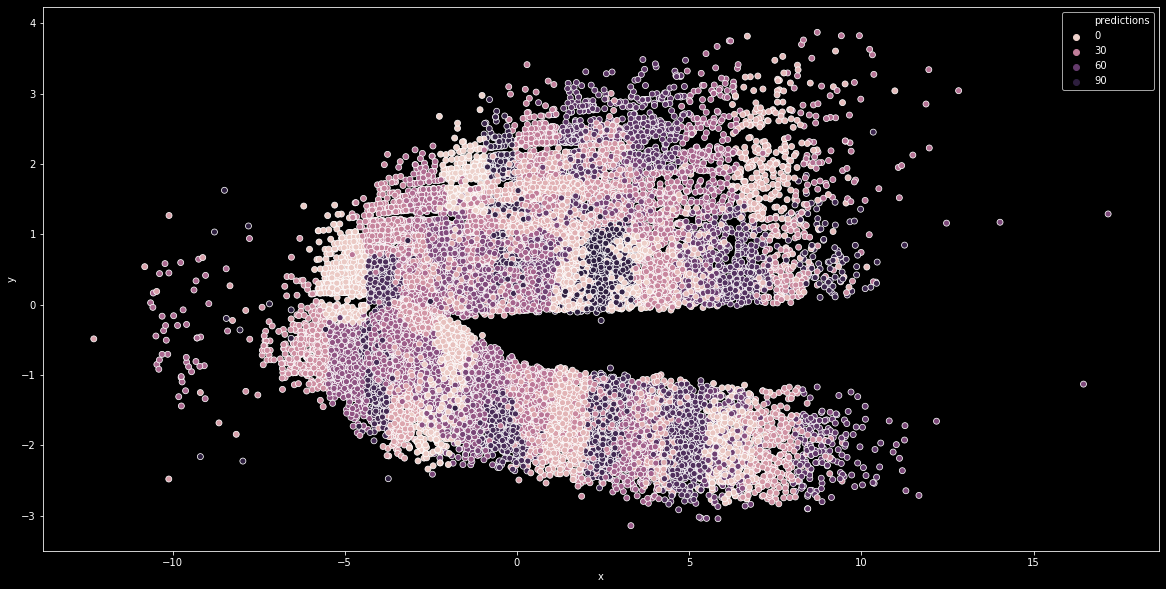

In [88]:
#add the predictions to the pca component
pca_components['predictions'] = y_pred
#size it
fig, ax = plt.subplots(figsize=(20,10))

ax = sns.scatterplot(data=pca_components, x='x', y='y', hue='predictions')
#ax2 = sns.scatterplot(data=pca_components, x='x', y='y', hue='actuals', marker='+')
plt.show()

I definitely want to stick to UMAP for the visual representation of the data. The data for these principle components are too compressed to provide a good amount of visual decision making or analysis. Alright. 

When it comes to the UMAP, intuitively I will want to retain the minkowski metric as I have an assigned requirement to try to get a good representation of the data with kmeans. I'll bring back UMAP in a bit. Looking at the data and knowing what the principle analyisis is giving me and having seen several iterations of UMAP distributions,  I can say that my next k value should be between two and seven. I'll display the best result I can muster from kmeans. 

# K Means - Unsupervised Learning Model

In [89]:
#KMeans++
# Defining the k-means
#number of clusters.
num_c = 4
kmeans_cluster = KMeans(n_clusters=num_c, random_state=123)

# Fit model
kmeans_cluster.fit(X_std)
y_pred = kmeans_cluster.predict(X_std)

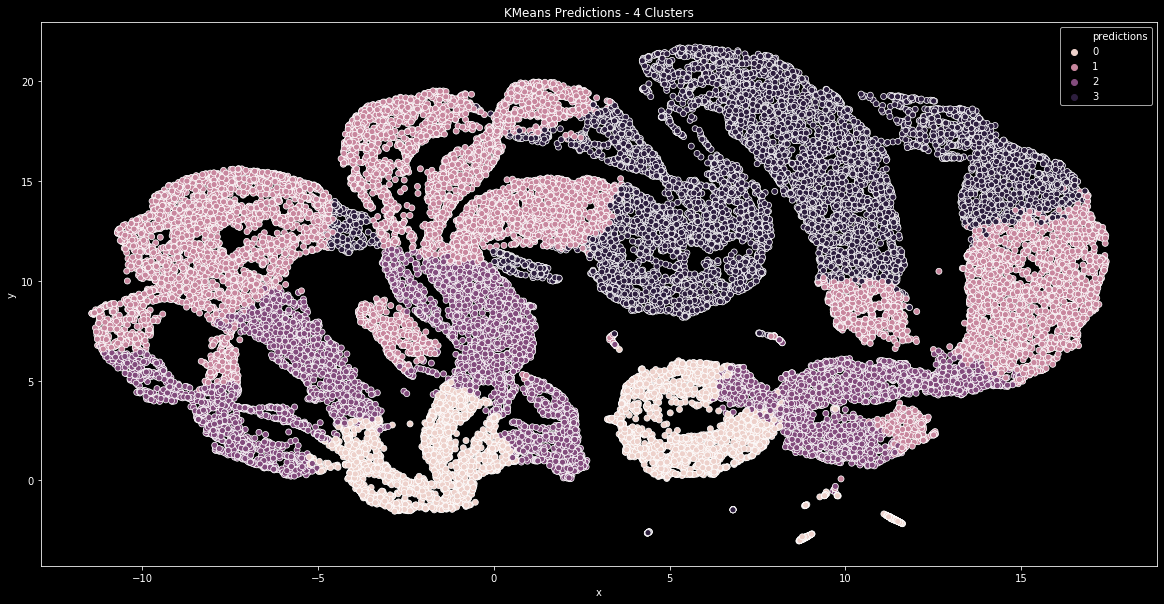

In [90]:
#Redefine umap. I don't know what I want it to look like, but not like it does.
umap_results = pd.DataFrame(umap.UMAP(n_neighbors=7, min_dist=0.3, metric='euclidean').fit_transform(X_std), columns=['x', 'y'])

#Same thing: make the predictions and map it. 
umap_results['predictions'] = y_pred

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=umap_results, x='x', y='y', hue='predictions')
ax.set_title('KMeans Predictions - {} Clusters'.format(num_c))
plt.show()

Alright, this looks like a decent representation of the kmeans solution with five clusters. 
What else do I want to say about this? I want to have a look at the data, actually - and see what kind of information I am deriving - that is; what exactly, kind of archetypes am I creating from the data?

This will or might help me determine if reducing or increasing the number of clusters may be helfpul in making some predictions. 

In [91]:
#Look a the means/centers of the data. This will give me an idea of what's manipulating the clusters. 
kmeans_results = pd.DataFrame(scale.inverse_transform(kmeans_cluster.cluster_centers_), columns=X.columns)
kmeans_results.style.background_gradient()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,67.581518,3859.895519,174.858606,41.444417,341.254603,14671.704877,277.299416,29730.669473,13.020094,229.865521,33.055462,151.011701,142.467923,320.057688
1,49.586215,1545.017874,126.582635,44.742273,227.452531,7072.390244,184.097753,14354.790790,8.683143,154.497296,24.728206,105.778423,100.343944,214.212519
2,57.379363,2513.726354,149.239988,45.272367,275.631089,11937.438884,221.830801,23929.414309,10.520739,184.190796,28.544810,123.886132,117.301410,259.615409
3,42.135691,1029.568775,106.521121,37.276695,188.833579,2809.943362,153.347683,4528.972080,7.210428,129.336489,21.089079,89.373843,84.806917,177.954738


# Goldilocks and the Three Bears
*It's a shame the gradient doesn't translate in github as of this writing. It's quite helpful.*

Just kidding. 
## Five 
<img src="images/k5.png" />


What I can discern from this table is that there are too many clusters, I think. It could be too few. I'm seeing the "we do it all", "we do some but not all" and, well it just goes down from there. It looks like I have slower/fewer participating as people get older and right around the age of 43/45, folks to really start to pick up the pace at a marathon. It's not a hard number, though, there are a number of marathon runners that will ... okay. so that's k5. I'm going to reduce this down a little and see if I get anything that's more satisfactory. 

## Three

<img src="images/k3.png" />

Okay I'm torn. Five tells me some great details. I forgot what I was complaining about it with five? Too detailed? I completely forgot.

Here I see that we have three archetypes. I can see that age is a key identifier; it tends to take the lead in the separation of these clusters. Here it's telling me that on average at about the age of 42, we start to slow down a little when it comes to running a marathon. 

41 - we said 43/45 earlier - is when we start taking off - and 38 is when we're just getting started. 

My third note for kmeans is going to run a four specter. 

## Four
<img src="images/k4.png" />
I'm most confident in this four cluster solution, coincidentally. Five made it difficult to discern. It wasn't too difficult, but things don't appear as obvious with it. There are too few cut and dry corners. 

Three was too few. I felt like there was more information to it.

And four looks just right and with that, I dub this section: Goldilocks and the Three Bears. 

In [92]:
title = 'KMeans'
print("The silhoutte score of the {} solution: {}"
      .format(title, metrics.silhouette_score(X_std, y_pred, metric='minkowski')))

The silhoutte score of the KMeans solution: 0.30084902090583754


I'm learning that this silhoutte score doesn't necessarily mean much with regards to correctness of clustering. According to this score my clusters have quite a bit of similarity to each other. That said, the geometry of the data is not flat. I suppose I could try this against the UMAP version of the data. Out of curiousity. 

In [93]:
title = 'KMeans'
print("The silhoutte score of the {} solution: {}"
      .format(title, metrics.silhouette_score(umap_results[['x','y']], y_pred, metric='minkowski')))

The silhoutte score of the KMeans solution: 0.11050325327127157


Knowing that the data does have some similarities in it, I can say that it is understandable that the score is this low. 
I can also acknowledge that the data is not two dimensional, that is to say; it's not a flat surface that I'm comparing against, so there's little help with this score. I'll take it as it is. 

I'm happiest with the four cluster result from kmeans. These are the predictions that I am using. 

I will concatenate the results to a results table for perusing the clusters during a review.

In [102]:
#Concatenate the cluster assignments to the orignal data. 
kmarathon = X.copy()
kmarathon['predictions'] = y_pred
kmarathon

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k,predictions
0,17.37,8,47.67,47,85.25,8,71.40,8,3.27,59.18,8.02,39.72,37.65,80.43,3
1,32.58,1,82.43,33,138.95,1,116.37,21,5.30,99.33,16.22,69.47,65.83,132.10,3
2,16.62,1,45.80,41,80.60,1,67.42,1,3.08,56.45,7.75,38.03,36.10,76.10,3
3,32.57,3,82.43,24,140.58,3,116.37,27,5.37,99.33,16.20,69.47,65.83,132.95,3
4,17.12,2,46.37,40,81.23,2,67.83,2,3.10,57.03,8.02,38.60,36.58,76.72,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31979,50.72,3414,124.02,32,211.75,7500,174.90,9849,8.08,148.65,26.13,104.78,99.55,200.22,1
31980,61.28,5212,165.02,34,302.52,15459,244.70,27456,11.55,203.43,31.07,135.85,128.37,285.47,0
31981,59.00,5231,157.02,21,282.00,10788,229.62,25092,10.77,192.65,28.18,130.57,123.33,266.30,2
31982,63.75,5800,167.82,38,302.73,12009,247.18,27476,11.55,207.52,30.98,137.03,129.90,285.87,0


# Gaussian Mixture Modeling

The PCA modeling technique reveals my data to look like a giant sphere almost. When I imaging what it might look like when I piece it back together after the UMAP, it will look like pacman. 

I could go in with DBScan and run up and down the ribbon to get my clusters. Radial should work here, though. It should work best with pacman and I think Guassian will boost it just right. 

I'll stick with the same UMap. However am I going to handle those results? Predictions probably wasn't the best name for that results table. **_Hrmph_**. Hindsight. 

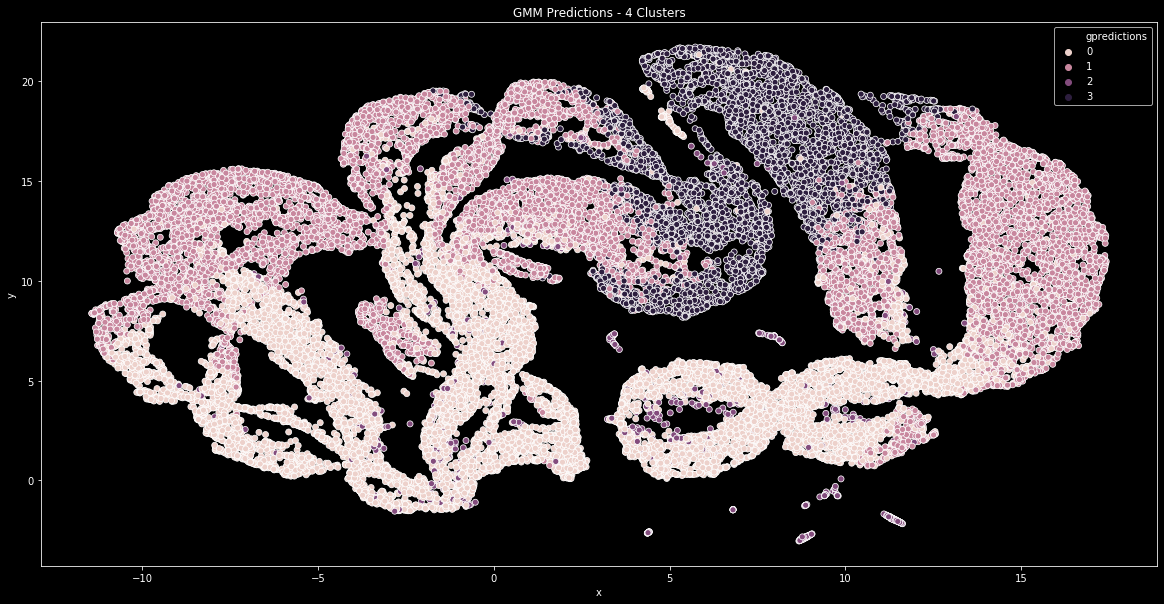

In [104]:
# Defining the agglomerative clustering
num_c = 4
gmm_cluster = GaussianMixture(n_components=num_c, random_state=123)

# Fit model
y_pred = gmm_cluster.fit_predict(X_std)

#Same thing: make the predictions and map it. 
umap_results['gpredictions'] = y_pred

fig, ax = plt.subplots(figsize=(20,10))
ax = sns.scatterplot(data=umap_results, x='x', y='y', hue='gpredictions')
ax.set_title('GMM Predictions - {} Clusters'.format(num_c))
plt.show()

In [105]:
#Look a the means/centers of the data. This will give me an idea of what's manipulating the clusters. 
gmm_results = pd.DataFrame(scale.inverse_transform(gmm_cluster.means_), columns=X.columns)
gmm_results.style.background_gradient()

,10k,division,25k,age,official,genderdiv,35k,overall,pace,30k,5k,half,20k,40k
0,58.286796,2774.618830,153.589017,43.750568,283.870045,11994.033356,228.930328,24043.679501,10.835335,190.016004,28.858780,126.987992,120.197846,267.657328
1,48.442682,1394.236649,123.060825,42.463989,218.586218,5737.936815,177.860148,11903.267821,8.345234,149.780904,24.183342,103.197411,97.792099,206.185052
2,59.749415,3304.621060,118.812933,43.070795,336.930084,13519.372270,260.549564,27107.072328,12.831479,211.078598,29.214851,132.772832,126.531275,299.354560
3,41.291045,827.808904,103.826235,38.676403,181.008481,2526.172595,148.095657,2867.697421,6.912009,125.586296,20.682591,87.410632,82.870215,170.862920


A four cluster in Guassian compares quite nicely to the KMeans metric. I'm going to stick with this cluster as the best for my Gaussian Mixed Model. Things look about right at this number, except my split is much closer for people in their early 40s. . 

Am I going with Gausian or am I going with kmeans? First, let me update my results table. I . . . accidentally named it kmarathon. 

Does that mean I'm partial?

In [109]:
#unsupervised marathon table
umarathon = runners.copy()
umarathon['gpreds'] = y_pred
umarathon['kpreds'] = kmarathon['predictions']

# Visualization

Alright. We discussed some of what and how the data starts to speak to us with these two different models; however that was through a mere glance at what the means looks like and is not a true representation of the data. 

Now I'm going to pull together one or two graphs to get an idea about what these clusters look like for guassian and k means. 

## K Means

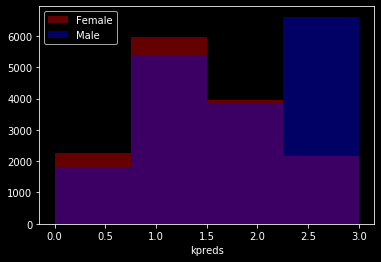

In [134]:
#bins = range(0, 100, 10)

ax = sns.distplot(umarathon.kpreds[umarathon.gender=='F'],
              color='red', kde=False, bins=bins, label='Female')
sns.distplot(umarathon.kpreds[umarathon.gender=='M'],
         ax=ax,  # Overplots on first plot
         color='blue', kde=False, bins=bins, label='Male')
plt.legend()
plt.show()

In [ ]:
bins = range(0, 100, 10)

ax = sns.distplot(umarathon.age,
              color='red', kde=False, bins=bins, label='Female')
sns.distplot(umarathon.kpreds[umarathon.gender=='M'],
         ax=ax,  # Overplots on first plot
         color='blue', kde=False, bins=bins, label='Male')
plt.legend()
plt.show()

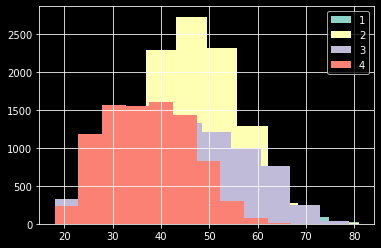

In [143]:
umarathon.groupby(by='kpreds').age.hist()
plt.legend(labels=['1','2','3','4'])
plt.show()

## Gaussian Mixture Model

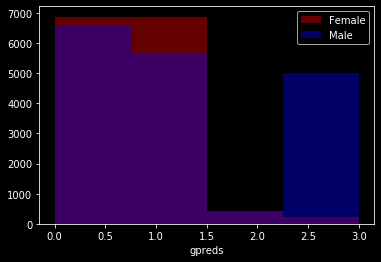

In [147]:
#bins = range(0, 100, 10)

ax = sns.distplot(umarathon.gpreds[umarathon.gender=='F'],
              color='red', kde=False, bins=bins, label='Female')
sns.distplot(umarathon.gpreds[umarathon.gender=='M'],
         ax=ax,  # Overplots on first plot
         color='blue', kde=False, bins=bins, label='Male')
plt.legend()
plt.show()

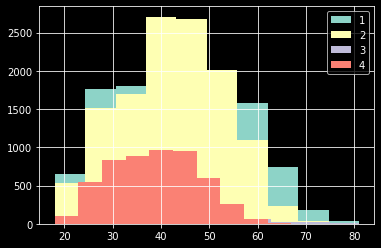

In [146]:
umarathon.groupby(by='gpreds').age.hist()
plt.legend(labels=['1','2','3','4'])
plt.show()